In [1]:
begin
    using Pkg
    Pkgs = ["CSV", "DataFrames", "Ipopt", "JuMP", "Plots", "PowerModels", "PowerPlots", "DelimitedFiles", "LaTeXStrings", "GLPK"]
    for p in Pkgs
        if Base.find_package(p) == nothing
            Pkg.add(p)
        end
    end

    using CSV, DataFrames, Ipopt, JuMP, Plots, PowerModels, PowerPlots, DelimitedFiles, LaTeXStrings, GLPK
end

# OPF in Distribution Networks
## DistFlow: 
* NLP-DistFlow -- Non-Linear Programming
* LinDistFlow -- Linear Programming (convex)

# Data
Let us get some data

In [2]:
case = parse_file("data/case4_dist.m")

[warn | PowerModels]: The number of generators (2) does not match the number of generator cost records (0).
[warn | PowerModels]: this code only supports angmin values in -90 deg. to 90 deg., tightening the value on branch 1 from -360.0 to -60.0 deg.
[warn | PowerModels]: this code only supports angmax values in -90 deg. to 90 deg., tightening the value on branch 1 from 360.0 to 60.0 deg.
[warn | PowerModels]: this code only supports angmin values in -90 deg. to 90 deg., tightening the value on branch 2 from -360.0 to -60.0 deg.
[warn | PowerModels]: this code only supports angmax values in -90 deg. to 90 deg., tightening the value on branch 2 from 360.0 to 60.0 deg.
[warn | PowerModels]: this code only supports angmin values in -90 deg. to 90 deg., tightening the value on branch 3 from -360.0 to -60.0 deg.
[warn | PowerModels]: this code only supports angmax values in -90 deg. to 90 deg., tightening the value on branch 3 from 360.0 to 60.0 deg.
[warn | PowerModels]: no active generato

Dict{String, Any} with 13 entries:
  "bus"            => Dict{String, Any}("4"=>Dict{String, Any}("zone"=>1, "bus_…
  "source_type"    => "matpower"
  "name"           => "case4_dist"
  "dcline"         => Dict{String, Any}()
  "source_version" => "2"
  "gen"            => Dict{String, Any}("1"=>Dict{String, Any}("qc1max"=>0.0, "…
  "branch"         => Dict{String, Any}("1"=>Dict{String, Any}("br_r"=>0.003, "…
  "storage"        => Dict{String, Any}()
  "switch"         => Dict{String, Any}()
  "baseMVA"        => 1
  "per_unit"       => true
  "shunt"          => Dict{String, Any}()
  "load"           => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>Any…

[warn | PowerModels]: Component type shunt is not yet not supported
[warn | PowerModels]: Component type storage is not yet not supported
[warn | PowerModels]: Component type switch is not yet not supported
[warn | PowerPlots]: Data column "ComponentType" does not exist for DC line


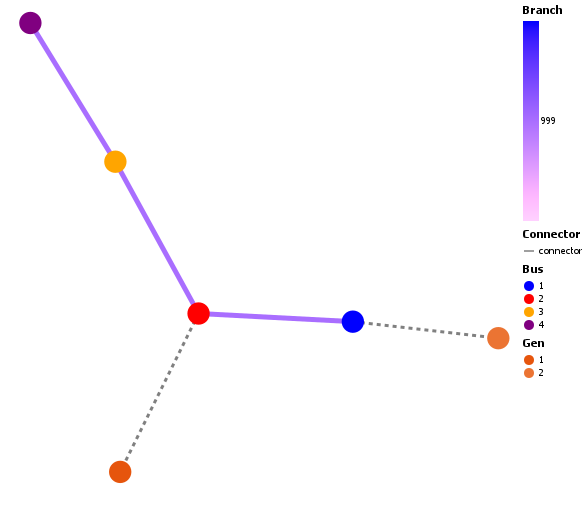

In [3]:
powerplot(case;
    gen_data=:index,
    bus_data=:index,
    bus_color=[:blue, :red, :orange, :purple],
    branch_data=:rate_a,
    branch_color=[:white,:blue],
    branch_data_type=:quantitative
)

In [4]:
S_base = readdlm("data/BaseMVA.txt")[1,1]

1.0

In [5]:
BusData = CSV.read("data/bus.csv", DataFrame)
GenData = CSV.read("data/gen.csv", DataFrame)
GenCostData = CSV.read("data/gencost.csv", DataFrame)
X = readdlm("data/X.csv")
R = readdlm("data/R.csv")
S = readdlm("data/S.csv")

4×4 Matrix{Float64}:
   0.0  999.0    0.0  999.0
 999.0    0.0  999.0    0.0
   0.0  999.0    0.0    0.0
 999.0    0.0    0.0    0.0

In [6]:
R

4×4 Matrix{Float64}:
 0.0    0.003  0.0    0.003
 0.003  0.0    0.003  0.0
 0.0    0.003  0.0    0.0
 0.003  0.0    0.0    0.0

In [7]:
Buses = 1:size(BusData)[1]
Gens = 1:size(GenData)[1]
Z = R + im * X

4×4 Matrix{ComplexF64}:
   0.0+0.0im    0.003+0.006im    0.0+0.0im    0.003+0.006im
 0.003+0.006im    0.0+0.0im    0.003+0.006im    0.0+0.0im
   0.0+0.0im    0.003+0.006im    0.0+0.0im      0.0+0.0im
 0.003+0.006im    0.0+0.0im      0.0+0.0im      0.0+0.0im

In [8]:
GenData

,bus,Pg,Qg,Qmax,Qmin,Vg,mBase,status,Pmax
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2.0,0.0,0.0,999.0,-999.0,1.05,100.0,1.0,999.0
2,1.0,0.0,0.0,999.0,-999.0,1.05,100.0,1.0,999.0


In [9]:
GenCostData

,2,startup,shutdown,n,c1,c0
,Float64,Float64,Float64,Float64,Float64,Float64
1,2.0,0.0,0.0,2.0,20.0,0.0
2,2.0,0.0,0.0,2.0,10.0,0.0


# NLP DistFlow

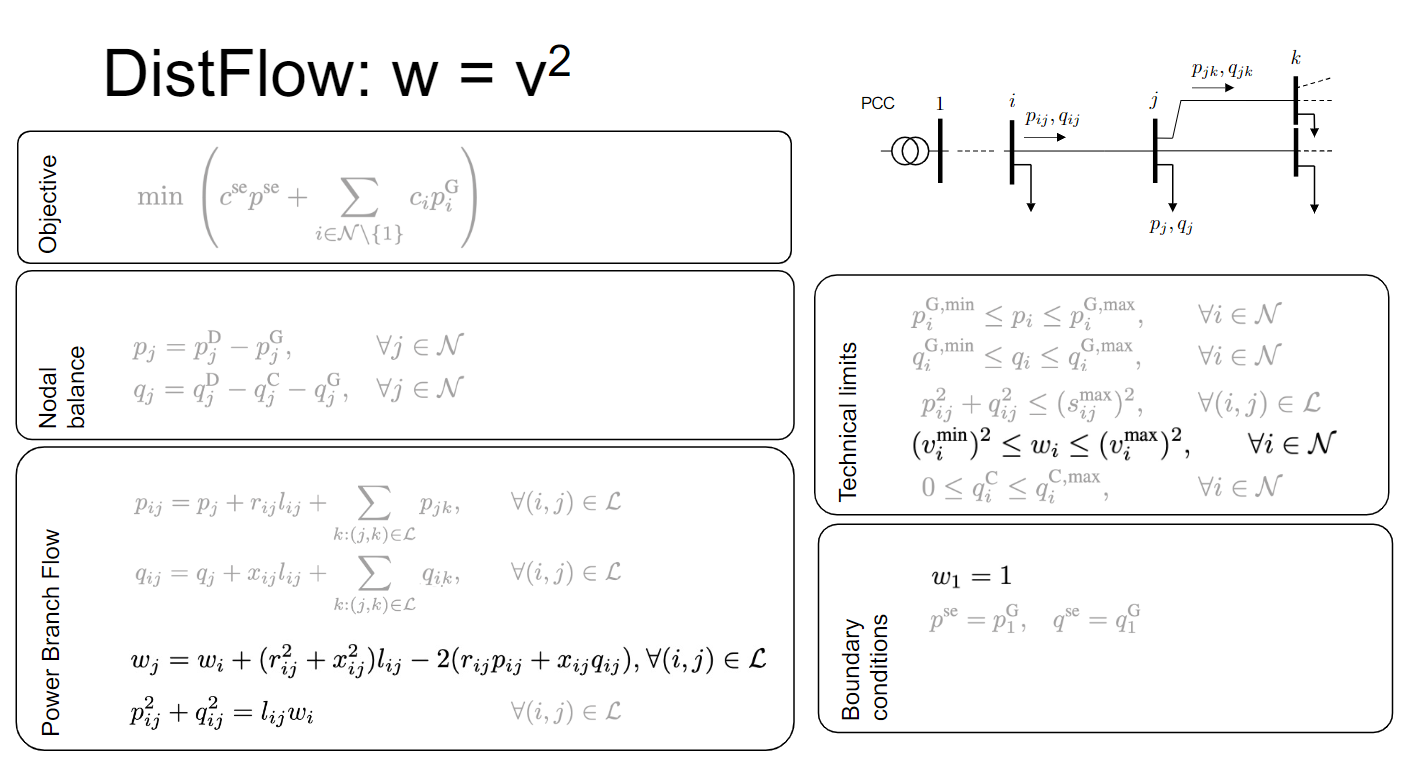

# <font color='green'>Tree structure </font>
> 1. We are exploiting *Tree structure* of the *distribution* grid
> 2. Tree <=> no loops <=> there is only one path from bus `i` to bus `j`
> 3. Each bus has **only one parent bus**
> 4. **Pay attention** to the comments at, e.g., line 24 -- we do the same for each variable related for a branch

# <font color='green'> Boundary condition: root power injection </font>
> I. <font color='blue'>**Problem** </font>: **Root** of the tree (the bus that actually is a beginnig of the grid) **has no parent!** No branch comes **into** the root. Thus,  **There is no balance equation for the root.**

> II. <font color='blue'>**Reason**</font>: We define power injection at bus `j` by considering 
> * Incoming flow from **parent**
> * Injection by generator and demand
> * Losses on the line from parent to current bus `j`
> * Flows that are **leaving** this bus `j`

>$$
\underset{\texttt{Flow from parent}}{\underbrace{p_{ij}}} = \underset{\texttt{Power injection}}{\underbrace{p_j^D - p_j^G}}  + \underset{\texttt{Losses on line from parent}}{\underbrace{r_{ij} l_{ij}}}  + \underset{\texttt{Leaving flows}}{\underbrace{\sum_{k: (j, k), ~ k \in \mathcal{L}} p_{jk}}},  ~ \forall (i, j) \in \mathcal{L}
$$
*Note that $j$ **never equals 1.** Which means, there is no balance equation for root bus.* 

> III. <font color='blue'>**Solution**</font>: Boundary conditions to handle root balance:
$$
\underset{\texttt{No flow is coming into}}{\underbrace{0}} = \underset{\texttt{Injection}}{\underbrace{p_1^D - p_1^G}}  + \underset{\texttt{No branch is coming into - no losses}}{\underbrace{0}} + \underset{\texttt{Leaving flows}}{\underbrace{\sum_{k: (1, k), ~ k \in \mathcal{L}} p_{1k}}}
$$
$$
\underset{\texttt{No flow is coming into}}{\underbrace{0}} = \underset{\texttt{Injection}}{\underbrace{q_1^D - q_1^G}}  + \underset{\texttt{No branch is coming into - no losses}}{\underbrace{0}} + \underset{\texttt{Leaving flows}}{\underbrace{\sum_{k: (1, k), ~ k \in \mathcal{L}} q_{1k}}}
$$

In [10]:
function NLPDF(BusData, GenData, GenCostData, Buses, Gens, R, X, Z, S)
    """
    This function implements non-linear distflow formulation for OPF  in application for distribution grids
    
    Arguments:
        BusData (DataFrame): containts data  about buses
        GenData (DataFrame): containts data  about gens: limits, positions
        GenCostData (DataFrame): containts data  about gens' cost
        Buses (UnitRange{Int64}): indexes of buses
        Gens (UnitRange{Int64}): indexes of generators
        R, X, Z, S (Matrix{Float64}): resistances, reactances, impedances and flow limits of lines, resp.
    Returns:
        JuMP.Model: optimized model for non-linear distflow
    """
    DF_NLP = Model(Ipopt.Optimizer)
    
    # Variables
    ## Nodal
    @variable(DF_NLP, BusData[i, :Vmin]^2 ≤ w[i in Buses] ≤ BusData[i, :Vmax]^2, start=1.0)
    @variable(DF_NLP, GenData[g, :Pmin] ≤ p[g in Gens] ≤ GenData[g, :Pmax])
    @variable(DF_NLP, GenData[g, :Qmin] ≤ q[g in Gens] ≤ GenData[g, :Qmax])
    ## Line
    ### active flow
    ### we use (j > i) condition to move from root (bus 1) to its children, as well as from bus i to its children
    @variable(DF_NLP, pij[i in Buses, j in Buses; abs.(Z[i, j]) != 0. && (j > i)])
    #reactive flow
    @variable(DF_NLP, qij[i in Buses, j in Buses; abs.(Z[i, j]) != 0. && (j > i)])
    #current
    @variable(DF_NLP, 0 ≤ l[i in Buses, j in Buses; abs.(Z[i, j]) != 0. && (j > i)])
    
    # Constraints
    
    ## Boundary condition at root bus (the one that has no parent nodes)
    ### No branch, no flow comes into root bus, but there is an power injection
    @constraint(DF_NLP, PlineRootBalance,
        0. == BusData[1, :Pd] - sum(p[g] for g in Gens if GenData[g, :bus] == 1)  + 0. +
                sum(pij[1, k] for k in Buses if Z[1, k] != 0.)
    )
    @constraint(DF_NLP, QlineRootBalance,
        0. == BusData[1, :Qd] - sum(q[g] for g in Gens if GenData[g, :bus] == 1)  + 0. +
                sum(qij[1, k] for k in Buses if Z[1, k] != 0.)
    )
    
    ## Active branch flow
    ### we use (j > i) condition to move from root (bus 1) to its children, as well as from bus i to its children
    @constraint(DF_NLP, Pline[i in Buses, j in Buses; abs.(Z[i, j]) != 0. && (j > i)], 
        pij[i, j] == BusData[j, :Pd] - sum(p[g] for g in Gens if GenData[g, :bus] == j) + R[i, j] * l[i, j]  +
                sum(pij[j, k] for k in Buses if (k != i && Z[j, k] != 0.))
    )
    ## Reactive branch flow
    ### we use (j > i) condition to move from root (bus 1) to its children, as well as from bus i to its children
    @constraint(DF_NLP, Qline[i in Buses, j in Buses; abs.(Z[i, j]) != 0. && (j > i)], 
        qij[i, j] == BusData[j, :Qd] - sum(q[g] for g in Gens if GenData[g, :bus] == j) + X[i, j] * l[i, j]  +
                sum(qij[j, k] for k in Buses if (k != i && Z[j, k] != 0.))
    )
    ## Apparent branch flow
    ### we use (j > i) condition to move from root (bus 1) to its children, as well as from bus i to its children
    @NLconstraint(DF_NLP, Sflow[i in Buses, j in Buses; abs.(Z[i, j]) != 0. && (j > i)],
        pij[i, j]^2 + qij[i, j]^2  == l[i,j] * w[i] 
    )
    
    ## Branch Voltage Drop
    @NLconstraint(DF_NLP, Vdrop[i in Buses, j in Buses; abs.(Z[i, j]) != 0. && (j > i)],
        w[j] == w[i] + (R[i, j]^2 + X[i, j] ^2 ) * l[i, j] - 2 * (R[i, j] * pij[i, j] + X[i, j] * qij[i, j])
    )
    ## Line capacity
    @NLconstraint(DF_NLP, Smax[i in Buses, j in Buses; abs.(Z[i, j]) != 0. && (j > i)],
        pij[i, j]^2 + qij[i, j]^2 ≤ S[i, j]^2 
    )
    
    # Objective
    @objective(DF_NLP, Min, sum(GenCostData[g, :c0] + S_base * GenCostData[g, :c1] * p[g] for g in Gens))
    
    optimize!(DF_NLP)
    
    return DF_NLP
end

NLPDF (generic function with 1 method)

In [11]:
# Solve it!
mNLP = NLPDF(BusData, GenData, GenCostData, Buses, Gens, R, X, Z, S)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       49
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:       17
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        8
                     variables with only upper bounds:        0
Total number of equal

A JuMP Model
Minimization problem with:
Variables: 17
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 8 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 11 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 8 constraints
Nonlinear: 9 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Ipopt
Names registered in the model: Pline, PlineRootBalance, Qline, QlineRootBalance, Sflow, Smax, Vdrop, l, p, pij, q, qij, w

In [12]:
# Objective value
objective_value(mNLP)

12.025927637428035

In [13]:
value.(mNLP[:w])

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:4
And data, a 4-element Vector{Float64}:
 1.2099998957050841
 1.2052233421215366
 1.2004158447196658
 1.2051924280179407

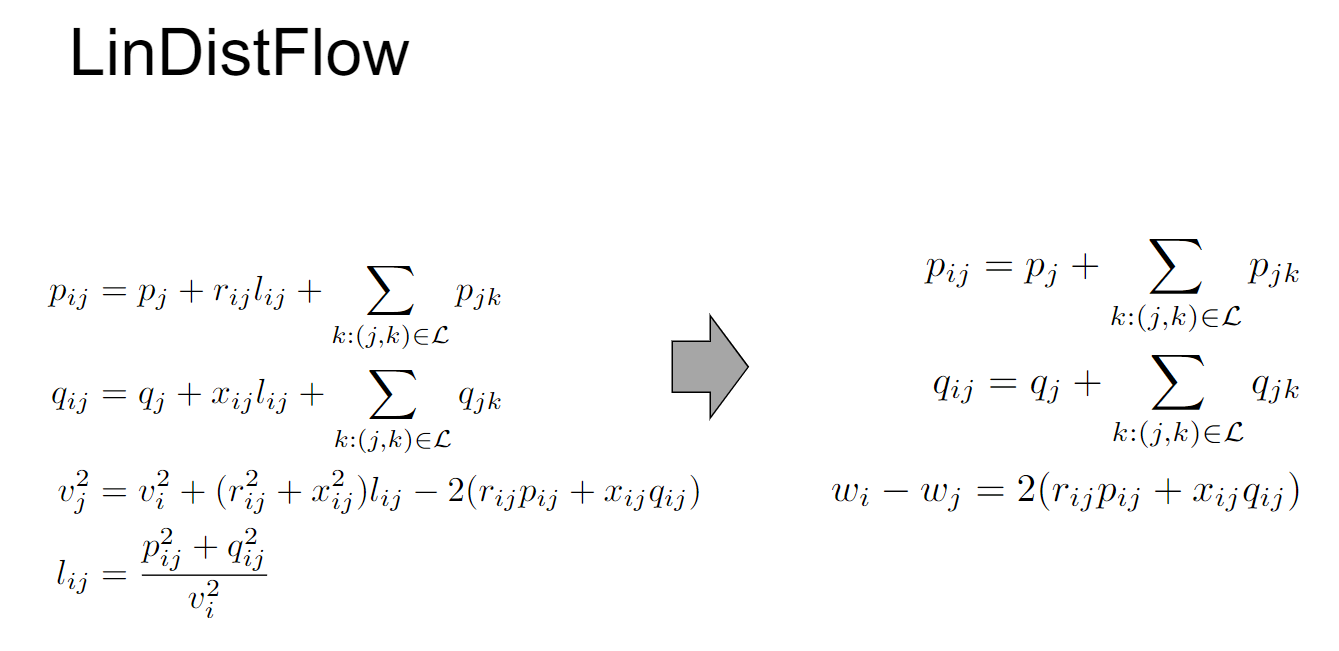

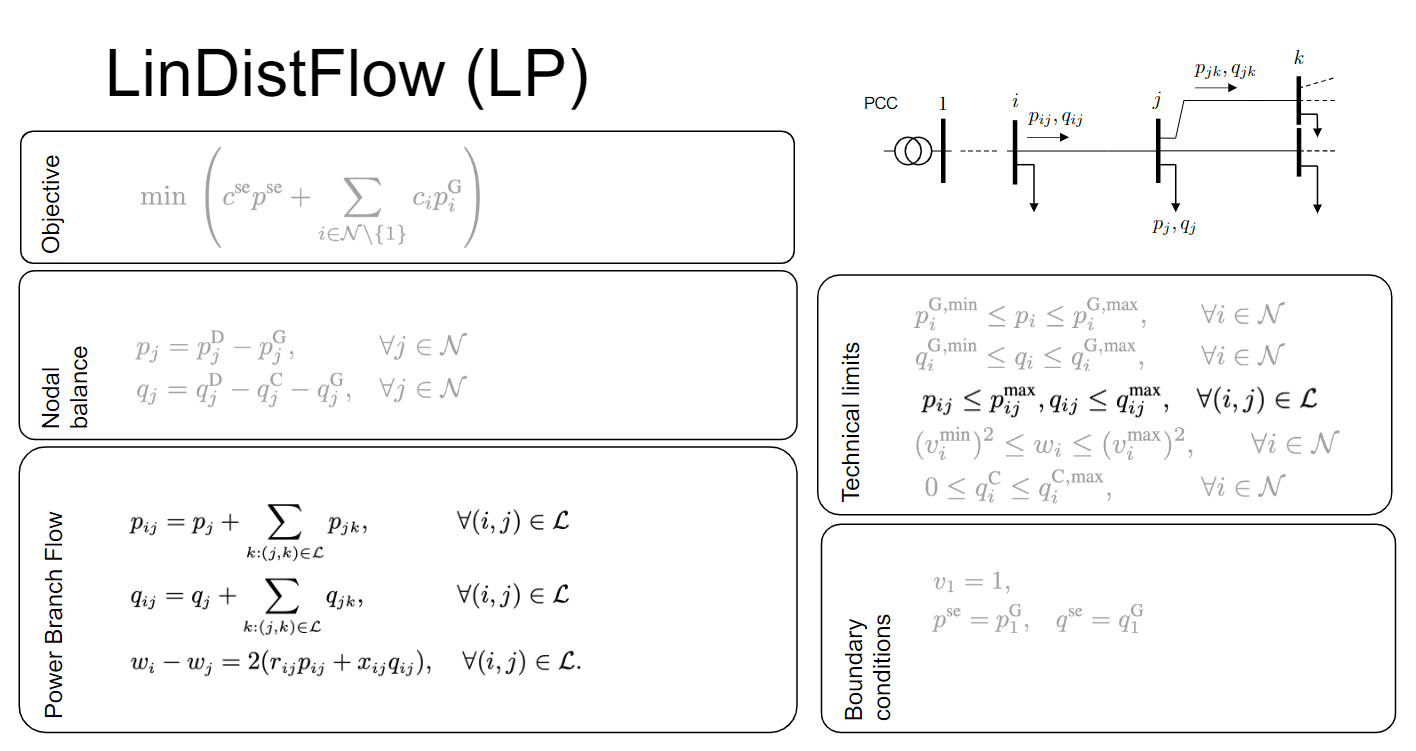

## Use solver for linear problem -- GLPK

In [14]:
function LPDF(BusData, GenData, GenCostData, Buses, Gens, R, X, Z, S)
    """
    This function implements linear distflow formulation for OPF  in application for distribution grids
    
    Arguments:
        BusData (DataFrame): containts data  about buses
        GenData (DataFrame): containts data  about gens: limits, positions
        GenCostData (DataFrame): containts data  about gens' cost
        Buses (UnitRange{Int64}): indexes of buses
        Gens (UnitRange{Int64}): indexes of generators
        R, X, Z, S (Matrix{Float64}): resistances, reactances, impedances and flow limits of lines, resp.
    Returns:
        JuMP.Model: optimized model for linear distflow
    """
    DF_LP = Model(GLPK.Optimizer)
    
    #Variables
    ## Nodal
    @variable(DF_LP, BusData[i, :Vmin]^2 ≤ w[i in Buses] ≤ BusData[i, :Vmax]^2, start=1.0)
    @variable(DF_LP, GenData[g, :Pmin] ≤ p[g in Gens] ≤ GenData[g, :Pmax])
    @variable(DF_LP, GenData[g, :Qmin] ≤ q[g in Gens] ≤ GenData[g, :Qmax])
    ## Line
    ### active flow
    ### we use (j > i) condition to move from root (bus 1) to its children, as well as from bus i to its children
    @variable(DF_LP, pij[i in Buses, j in Buses; abs.(Z[i, j]) != 0. && (j > i)])
    ### reactive flow
    @variable(DF_LP, qij[i in Buses, j in Buses; abs.(Z[i, j]) != 0. && (j > i)])
    
    #Constraints
    
    ## Boundary condition at root bus (the one that has no parent nodes)
    ### No branch, no flow comes into root bus, but there is an power injection
    @constraint(DF_LP, PlineRootBalance,
        0. == BusData[1, :Pd] - sum(p[g] for g in Gens if GenData[g, :bus] == 1)  +
                sum(pij[1, k] for k in Buses if Z[1, k] != 0.)
    )
    @constraint(DF_LP, QlineRootBalance,
        0. == BusData[1, :Qd] - sum(q[g] for g in Gens if GenData[g, :bus] == 1)  +
                sum(qij[1, k] for k in Buses if Z[1, k] != 0.)
    )
    
    ## Active branch flow
    ### we use (j > i) condition to move from root (bus 1) to its children, as well as from bus i to its children
    @constraint(DF_LP, Pline[i in Buses, j in Buses; abs.(Z[i, j]) != 0. && (j > i)], 
        pij[i, j] == BusData[j, :Pd] - sum(p[g] for g in Gens if GenData[g, :bus] == j) +
                sum(pij[j, k] for k in Buses if (k != i && Z[j, k] != 0.))
    )
    ## Reactive branch flow
    ### we use (j > i) condition to move from root (bus 1) to its children, as well as from bus i to its children
    @constraint(DF_LP, Qline[i in Buses, j in Buses; abs.(Z[i, j]) != 0. && (j > i)], 
        qij[i, j] == BusData[j, :Qd] - sum(q[g] for g in Gens if GenData[g, :bus] == j) +
                sum(qij[j, k] for k in Buses if (k != i && Z[j, k] != 0.))
    )
    
    ## Branch Voltage Drop
    ### we use (j > i) condition to move from root (bus 1) to its children, as well as from bus i to its children
    @constraint(DF_LP, Vdrop[i in Buses, j in Buses; abs.(Z[i, j]) != 0. && (j > i)],
        w[i] - w[j] ==  2 * (R[i, j] * pij[i, j] + X[i, j] * qij[i, j])
    )
    ##Line capacity
    @constraint(DF_LP, Pmax[i in Buses, j in Buses; abs.(Z[i, j]) != 0. && (j > i)],
        -S[i, j] ≤ pij[i, j] ≤ S[i, j]
    )
    @constraint(DF_LP, Qmax[i in Buses, j in Buses; abs.(Z[i, j]) != 0. && (j > i)],
        -S[i, j] ≤ qij[i, j] ≤ S[i, j]
    )
    
    # Objective
    @objective(DF_LP, Min, sum(GenCostData[g, :c0] + S_base * GenCostData[g, :c1] * p[g] for g in Gens))
    
    optimize!(DF_LP)
    return DF_LP
end

LPDF (generic function with 1 method)

In [15]:
# solve it
mLP = LPDF(BusData, GenData, GenCostData, Buses, Gens, R, X, Z, S);

┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{GLPK.Optimizer}. This information will be discarded.
└ @ MathOptInterface.Utilities C:\Users\aleks\.julia\packages\MathOptInterface\YDdD3\src\Utilities\copy.jl:290


In [16]:
# objective
objective_value(mLP)

12.000000000000114

In [17]:
value.(mLP[:w])


1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:4
And data, a 4-element Vector{Float64}:
 0.8148000000000001
 1.2100000000000002
 1.2052
 0.81

# Collecting data

In [18]:
P_LP = collect(value.(mLP[:p]))
P_NLP = collect(value.(mNLP[:p]))
Q_LP = collect(value.(mLP[:q]))
Q_NLP = collect(value.(mNLP[:q]))
Pij_NLP = value.(mNLP[:pij])
cost_LP = objective_value(mLP)
cost_NLP = objective_value(mNLP)
GenNLP = DataFrame()
GenNLP.P = []
GenNLP.Q = []
GenLP = DataFrame()
GenLP.P = []
GenLP.Q = []
for i in 1:length(P_NLP)
    push!(GenNLP, [P_NLP[i], Q_NLP[i]])
end
for i in 1:length(P_LP)
    push!(GenLP, [P_LP[i], Q_LP[i]])
end

[warn | PowerModels]: Component type shunt is not yet not supported
[warn | PowerModels]: Component type storage is not yet not supported
[warn | PowerModels]: Component type switch is not yet not supported
[warn | PowerPlots]: Data column "ComponentType" does not exist for DC line


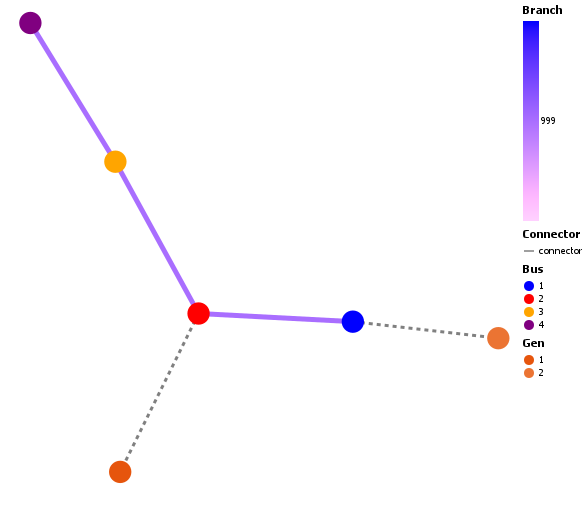

In [19]:
powerplot(case;
    gen_data=:index,
    bus_data=:index,
    bus_color=[:blue, :red, :orange, :purple],
    branch_data=:rate_a,
    branch_color=[:white,:blue],
    branch_data_type=:quantitative
)

In [20]:
println("NLP: Cost = ", cost_NLP, "\n", GenNLP)
println("LP: Cost = ", cost_LP, "\n", GenLP)

NLP: Cost = 12.025927637428035
2×2 DataFrame
 Row │ P        Q        
     │ Any      Any      
─────┼───────────────────
   1 │ 0.0      0.405197
   2 │ 1.20259  0.199988
LP: Cost = 12.000000000000114
2×2 DataFrame
 Row │ P    Q        
     │ Any  Any      
─────┼───────────────
   1 │ 0.0  33.7333
   2 │ 1.2  -33.1333


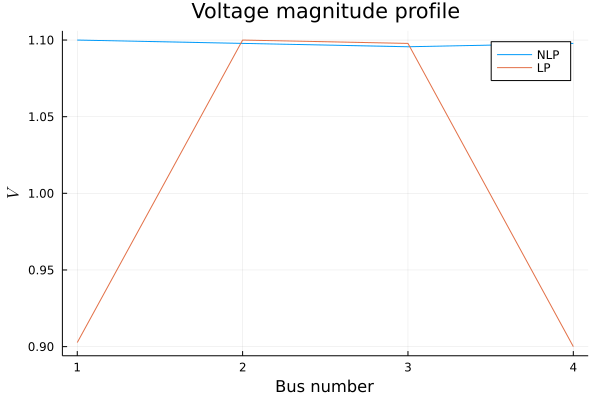

In [21]:
ws_NLP = collect(value.(mNLP[:w]))
ws_LP = collect(value.(mLP[:w]))
plot(sqrt.(ws_NLP), label="NLP")
plot!(sqrt.(ws_LP), label="LP")
plot!(xlabel="Bus number", ylabel=L"V")
plot!(title="Voltage magnitude profile")

In [22]:
N = length(Buses)
pij_NLP = zeros(N, N)
qij_NLP = zeros(N, N)
pij_LP = zeros(N, N)
qij_LP = zeros(N, N)
for i in Buses, j in Buses  
    if Z[i, j] != 0 && j > i
        ws = value.(mNLP[:w])
        ls = value.(mNLP[:l])
        pijs = value.(mNLP[:pij])
        qijs = value.(mNLP[:qij])
        scale_ij = sqrt(ls[i, j] * ws[i])
        pij_NLP[i, j] = pijs[i, j] / scale_ij
        qij_NLP[i, j] = qijs[i, j] / scale_ij
    end
end

for i in Buses, j in Buses 
    if Z[i, j] != 0 && j > i
        ws = value.(mLP[:w])
        pijs = value.(mLP[:pij])
        qijs = value.(mLP[:qij])
        scale_ij = sqrt((pijs[i, j] ^ 2 + qijs[i, j] ^ 2) / ws[i])
        pij_LP[i, j] = pijs[i, j] / scale_ij
        qij_LP[i, j] = qijs[i, j] / scale_ij
    end
end

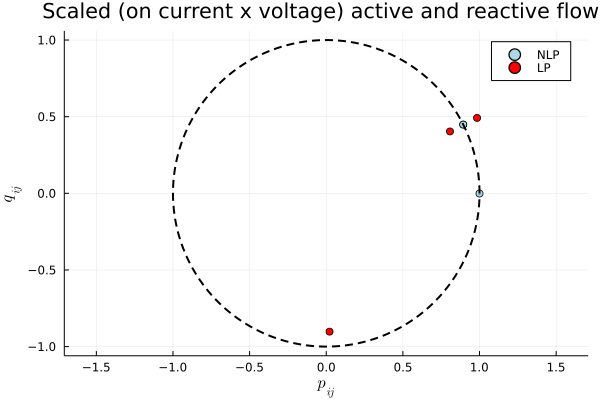

In [23]:
scatter([pij_NLP[pij_NLP .!= 0]], [qij_NLP[qij_NLP .!= 0]], label="NLP", color=:lightblue)
scatter!(pij_LP[pij_LP .!= 0], qij_LP[qij_LP .!= 0], label="LP", color=:red)
plot!(xlabel=L"p_{ij}", ylabel=L"q_{ij}")
θ = 0:0.01:2*pi
x_c, y_c = cos.(θ), sin.(θ)
plot!(x_c, y_c, line=(2, :dash), label="", color=:black)
plot!(aspect_ratio=:equal)
plot!(title="Scaled (on current x voltage) active and reactive flows")